# Composite Indicator

In [22]:
#importing libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
import warnings
from typing import Literal
warnings.filterwarnings('ignore')

%load_ext extensions.skip

# defining a style
sns.set(style='darkgrid')
colors_arr = ['#1a96d0', '#fe9c39']
colors = ['#1a96d0', '#fe9c39', '#25ba31', '#EC5A77']

/home/gisliany/anaconda3/envs/master-research/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [23]:
# choose the spatial unit: neighborhood or hdu
spatial_unit = 'hdu'

spatial_area_label = 'hdu_id' if spatial_unit == 'hdu' else 'neighborhood'

## 1. Loading the data

This provided dataset is the one obtained after the data cleaning stage mentioned in the article *"A composite indicator of liveability based on sociodemographic and Uber quality service dimensions: a data-driven approach"*.

In [24]:
df = pd.read_csv("./data/uber_{}.csv".format(spatial_unit), index_col=0)

In [25]:
df[spatial_area_label] = df[spatial_area_label].astype(str)

### 1.1. Preparing the data

In [26]:
# adding new variables
if spatial_unit == 'neighborhood':
  df['car_crimes_rate'] = 100000*(df['car_theft'] + df['car_robbery'])/df['population']
  df['urban_services_ratio'] = 100000*(df['education_units'] + df['health_units'] + df['security_units'])/df['population']

In [27]:
numeric_cols = list(df.select_dtypes(['float64', 'int64']).columns)

# Selecting numeric columns and standardizing the variables
numerical_data = df[numeric_cols]
scaler = StandardScaler()
# data have to be standardized, once this is a requirement to run FA
numerical_data = scaler.fit_transform(numerical_data)

df_numerical = pd.DataFrame(numerical_data, columns = numeric_cols)
df_numerical.shape

(58, 15)

## 2. Composite Indicator of Liveability (CIL)

### 2.1. Factor Analysis (FA)

#### 2.1.1. Checking correlations


**CORRELATIONS**

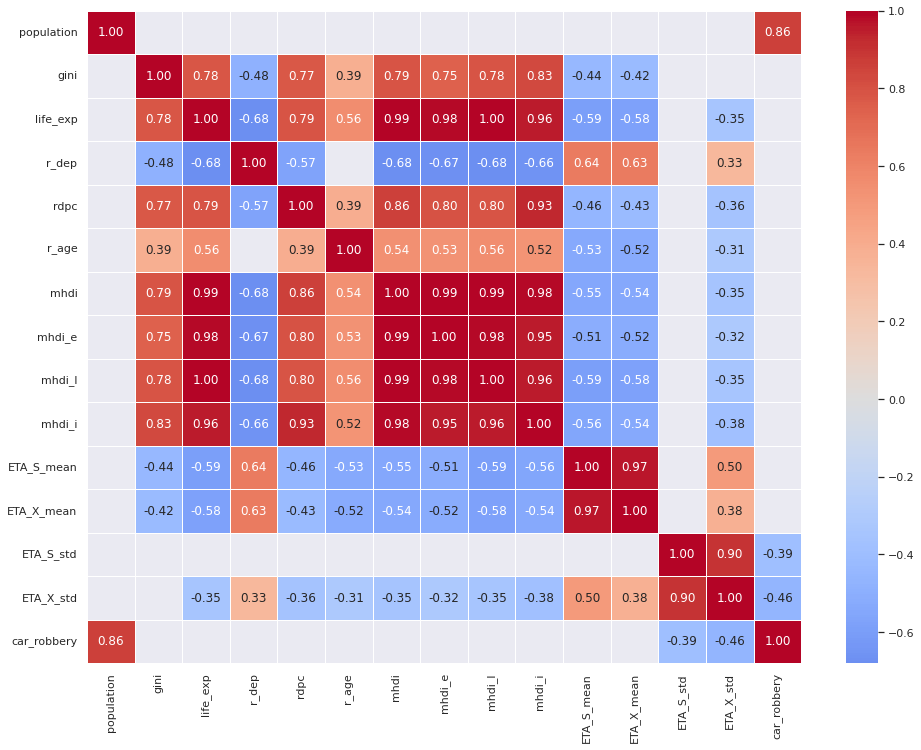

In [28]:
corr = df_numerical.corr()
fig, ax = plt.subplots(figsize=(16,12))

# Hiding the correlations that are smaller than 0.3
sns.heatmap(corr, mask = corr.abs() < 0.3, cmap="coolwarm", center=0, annot=True, fmt=".2f", linewidths=.5, ax=ax)
bottom, top = ax.get_ylim()

In [29]:
(corr.abs() < 0.3).sum().sum()/corr.shape[0]**2

0.3288888888888889

Initially, the Factor Analysis (FA) was undertaken considering neighborhood as unit of analysis. However, this dataset did not meet the suitability criteria for the FA implementation, mainly because its variables are mostly weakly correlated (about **57%** of the correlogram coefficients were less than 0.3 and more than **76%** were less than 0.5).  Consequently, it was not feasible to implement the indicator for this spatial aggregation level.

In the case of intra-neighborhood (HDU), three variables (population, car_robbery, ETA_S_std) with the highest amount of weak correlations had to be eliminated so that all the FA suitability criteria could be met.

In [30]:
# As the strong correlations were found only in the HDU dataset, we can skip the following steps for the neighborhood dataset
skip_cell = spatial_unit == 'neighborhood'

In [31]:
%%skip $skip_cell

df_numerical = df_numerical.drop(['population', 'car_robbery', 'ETA_S_std'], axis=1)

# checking the ratio of correlation values that are smaller than 0.3
corr = df_numerical.corr()
print((corr.abs() < 0.3).sum().sum()/corr.shape[0]**2)

0.027777777777777776


#### 2.1.2. suitability criteria

**STATISTICAL TESTS**

**Bartlett’s test** of sphericity checks whether or not the observed variables intercorrelate at all using the observed correlation matrix against the identity matrix. If the test found statistically insignificant, you should not employ factor analysis.

**Kaiser-Meyer-Olkin (KMO) test** measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variables and ranges between 0 and 1. In general, a KMO < 0.6 is considered inadequate.

In [39]:
def is_suitable_for_FA(df):
  chisquare, pvalue_bartlett = calculate_bartlett_sphericity(df)
  _, kmo_total = calculate_kmo(df)
  
  print('Check suitability')
  print('- Chi-square statistic is {:.4f}, with p-value {}'.format(chisquare, pvalue_bartlett))
  print('- Total KMO is {:.4f}'.format(kmo_total))

  # checks if Bartlett's test is significant (< 0.05) and the total KMO is at least 0.6 (>= 0.6).
  return pvalue_bartlett < 0.05 and kmo_total >= 0.6

#### 2.1.3. Factor Extraction using Principal Component Analysis (PCA) and factor rotation

In [69]:
def get_number_of_factors(df: pd.DataFrame):
  fa = FactorAnalyzer(n_factors=df.shape[1], method='principal', rotation=None)
  fa.fit(df)

  eigenvalues, _ = fa.get_eigenvalues()
  _, prop_variance, cum_variance = fa.get_factor_variance()
  n_factors = np.sum((eigenvalues > 1) & (prop_variance > 0.1))

  print('Number of factors: ', n_factors)
  print('- Proportion of variance explained by the {} factor(s): '.format(n_factors), prop_variance[:n_factors])
  print('- Proportion of cumulative variance of {} factor(s): '.format(n_factors), cum_variance[n_factors - 1])
  plot_factor_extraction(df, eigenvalues, prop_variance, cum_variance)

  return n_factors

def plot_eigenvalues(df, eigenvalues, ax):
  ax.scatter(range(1, df.shape[1]+1), eigenvalues)
  ax.plot(range(1, df.shape[1]+1), eigenvalues)
  ax.plot(range(1, df.shape[1]+1), [1] * df.shape[1], '--', linewidth=1.5, color="red")
  ax.set_xlabel('Factors')
  ax.set_ylabel('Eigenvalues')

def plot_explained_variance(prop_variance, ax):
  ax.bar(range(1, len(prop_variance) + 1), prop_variance)
  ax.set_xlabel('Number of components')
  ax.set_ylabel('Proportion of explained variance (%)')

def plot_cumulative_variance(cum_variance, ax):
  ax.plot(range(1, len(cum_variance) + 1), cum_variance)
  ax.scatter(range(1, len(cum_variance) + 1), cum_variance)
  ax.set_xlabel('Number of components')
  ax.set_ylabel('Proportion of cumulative variance (%)')

def plot_factor_extraction(df, eigenvalues, prop_variance, cum_variance, i = 1):
  fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,4))

  plot_eigenvalues(df, eigenvalues, axs[0])
  plot_explained_variance(prop_variance, axs[1])
  plot_cumulative_variance(cum_variance, axs[2])
  
  plt.show()

In [70]:
FILTERS = Literal['communalities', 'loadings']

def get_removable_features(by: FILTERS, fa: FactorAnalyzer, features):
  if by == 'communalities':
    return get_removable_features_by_communalities(fa, features)
  elif by == 'loadings':
    return get_removable_features_by_loadings(fa, features)

def get_removable_features_by_communalities(fa: FactorAnalyzer, features, threshold = 0.5):
  communalities = fa.get_communalities()
  return list(features[communalities < threshold])

def get_removable_features_by_loadings(fa: FactorAnalyzer, features, threshold = 0.4):
  condition = (abs(fa.loadings_) > threshold).all(axis=1)
  return list(features[condition])

In [71]:
def perform_factor_analysis(df, i=1):
  print('ITERATION #{}'.format(i))

  if (is_suitable_for_FA(df)):
    n_factors = get_number_of_factors(df)

    fa = FactorAnalyzer(n_factors=n_factors, method='principal', rotation='varimax')
    fa.fit(df)

    cols_to_drop = get_removable_features('communalities', fa, df.columns) or \
      get_removable_features('loadings', fa, df.columns)
    if len(cols_to_drop) > 0:
      return perform_factor_analysis(df.drop(columns=cols_to_drop, axis=1), i + 1)
    else:
      print_factors(fa, df.columns, n_factors)
    return fa, df.columns, n_factors

def print_factors(fa, features, n_factors):
  cols = ['Factor ' + str(i + 1) for i in range(n_factors)]
  factors_df = pd.DataFrame(np.copy(fa.loadings_), columns=cols, index=features)
  print(factors_df)


ITERATION #1
Check suitability
- Chi-square statistic is 2082.2473, with p-value 0.0
- Total KMO is 0.7618
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.67950291 0.12000813]
- Proportion of cumulative variance of 2 factor(s):  0.799511038111479


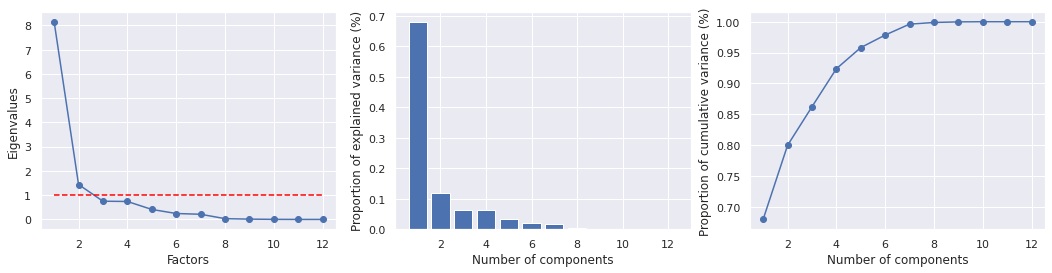

ITERATION #2
Check suitability
- Chi-square statistic is 2032.5848, with p-value 0.0
- Total KMO is 0.7581
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.76326504 0.13017519]
- Proportion of cumulative variance of 2 factor(s):  0.8934402312773262


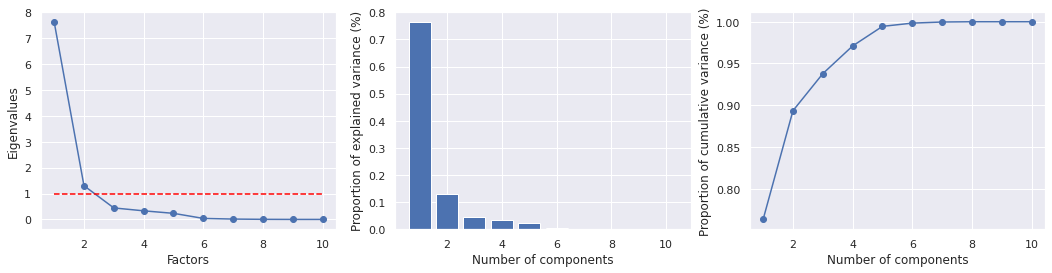

ITERATION #3
Check suitability
- Chi-square statistic is 1997.4026, with p-value 0.0
- Total KMO is 0.7284
Number of factors:  2
- Proportion of variance explained by the 2 factor(s):  [0.7881781 0.1372505]
- Proportion of cumulative variance of 2 factor(s):  0.9254285958368317


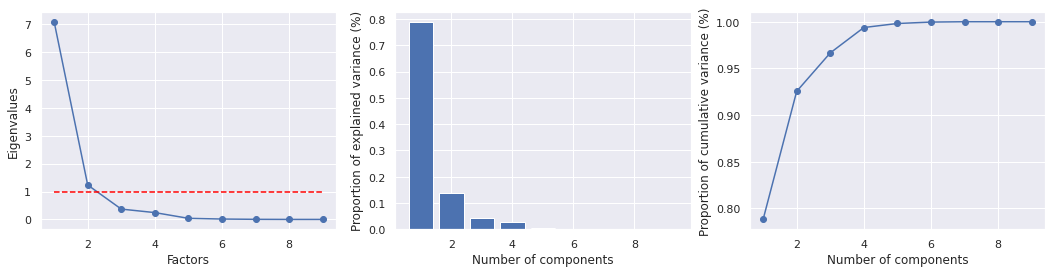

            Factor 1  Factor 2
gini        0.836155  0.185948
life_exp    0.917014  0.344599
rdpc        0.877399  0.184474
mhdi        0.947825  0.293080
mhdi_e      0.931359  0.269246
mhdi_l      0.917352  0.345173
mhdi_i      0.950045  0.284701
ETA_S_mean -0.295770 -0.945042
ETA_X_mean -0.279513 -0.950990


In [72]:
fa, features, n_factors = perform_factor_analysis(df_numerical)

#### 2.1.4. Visualizing results

In [73]:
# represents the data in terms of the obtained factors
cols_factors = ['Factor ' + str(i + 1) for i in range(n_factors)]
df_fa = pd.DataFrame(fa.fit_transform(df_numerical[features]), columns=cols_factors)

# select categorical columns to concat
df_categorical = df.select_dtypes(include=['object'])

# creates a dataset concating the categorical columns and the FA data
fa_data = pd.concat([df_categorical, df_fa], axis=1)
fa_data.hdu_id = fa_data.hdu_id.str[-2:]

The score plot graphs the HDU scores of the second factor versus the HDU scores of the first factor.

posx and posy should be finite values
posx and posy should be finite values


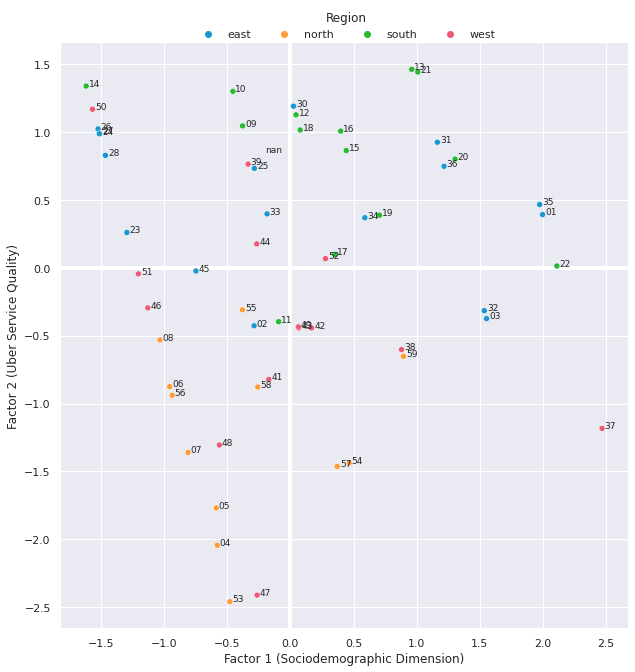

In [380]:
def label_points(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),fontsize=9)

g = sns.relplot(data=fa_data, x='Factor 1', y='Factor 2', hue='region', palette=colors, height=9, aspect=1)
g.set_axis_labels('Factor 1 (Sociodemographic Dimension)', 'Factor 2 (Uber Service Quality)')
sns.move_legend(g, 'lower center', bbox_to_anchor=(.5, 0.97), ncol=4, title='Region', frameon=False)
plt.axhline(y=0, linewidth=4, color='w', zorder=0)
plt.axvline(x=0, linewidth=4, color='w', zorder=0)
label_points(fa_data['Factor 1'], fa_data['Factor 2'], fa_data['hdu_id'], plt.gca())

### 2.2. Weighting

In [75]:
factor_loadings_df = pd.DataFrame(np.copy(fa.loadings_), columns=cols_factors, index=features)
for i, col in enumerate(factor_loadings_df.columns):
    squared_loadings = factor_loadings_df[col] ** 2
    factor_loadings_df[col] = np.round(squared_loadings/squared_loadings.sum(), 4)

In [390]:
largest = factor_loadings_df.stack().nlargest(factor_loadings_df.shape[0])
largest

ETA_X_mean  Factor 2    0.3859
ETA_S_mean  Factor 2    0.3811
mhdi_i      Factor 1    0.1508
mhdi        Factor 1    0.1501
mhdi_e      Factor 1    0.1449
mhdi_l      Factor 1    0.1406
life_exp    Factor 1    0.1405
rdpc        Factor 1    0.1286
gini        Factor 1    0.1168
dtype: float64